In [84]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from h5py import File

In [85]:
coloro = "#FF6C0C"
colorb = "#00A1DF"
colorgr = "#C8C8C8"
colorp = "#F54D80"

In [86]:
%run -i "Snippets/common_functions_and_variables.py"

In [87]:
with File("Data/PoroTomo_iDAS16043_160321073721.decimated.mat", 'r') as file:
    dt = file["dt"][()][0,0]
    nch = int(file["nch"][()][0,0])
    npts =  int(file["npts"][()][0,0])
    t0 =  file["t0"][()][0,0]
    data = file["data"][()]
    
with File("Data/PoroTomo_iDAS16043_160321073751.decimated.mat", 'r') as file:
    data = np.hstack((data, file["data"][()]))
    
# data = data[:, 1500:]

In [88]:
chan, x, y, z = np.loadtxt("Data/Surface_DAS_DTS_UTM_coordinates.csv", delimiter=',',skiprows=2, unpack=True)

xyselector = np.logical_and(x>10000,y>10000)

In [89]:
data = data[xyselector]
chan = chan[xyselector]
x = x[xyselector]
y = y[xyselector]
z = z[xyselector]
len(x)

8621

Text(0.5, 1.0, 'Channel = 5030')

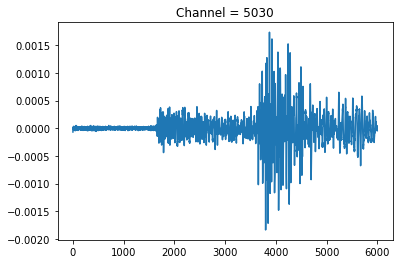

In [90]:
i = 5000
plt.plot(data[i]*11.6/1000)
plt.title(f"Channel = {int(chan[i])}")

In [91]:
azimuth = np.rad2deg(np.arctan2(x[1:]-x[:-1],y[1:]-y[:-1]))
corners = np.hstack([0, np.abs(azimuth[1:]-azimuth[:-1]) > 10, 0])
near_corners_selector = np.array([True for i in range(len(corners))])
for i, c in enumerate(corners):
    if c == 1:
        near_corners_selector[i-5:i+6] = False
        
azimuth = np.hstack([azimuth, azimuth[-1]]) # add an azimuth for the final channel

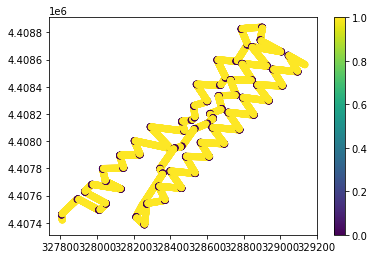

In [92]:
plt.scatter(x, y, c=near_corners_selector)
plt.colorbar()

In [93]:
data = data[near_corners_selector]
chan = chan[near_corners_selector]
x = x[near_corners_selector]
y = y[near_corners_selector]
z = z[near_corners_selector]
azimuth = azimuth[near_corners_selector]
len(x)

7804

In [94]:
from scipy.signal import butter, filtfilt, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=-1):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=axis)
    return y

def butter_lowpass_filter(data, lowcut, fs, order=5, axis=-1):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = filtfilt(b, a, data, axis=axis)
    return y

In [95]:
data_r = butter_bandpass_filter(data, 1, 5, 1/dt)[:,::10]
dt = dt*10
data = data_r

In [96]:
data_r.shape

(7804, 600)

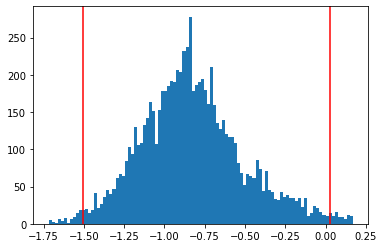

In [97]:
median_log_max_amp = np.log10(np.median(np.sort(np.abs(data_r), axis=1)[:,-10:], axis=1))

plt.hist(median_log_max_amp, 100)
q1 = np.quantile(median_log_max_amp,0.01)
q99 = np.quantile(median_log_max_amp,0.99)
plt.axvline(q1, c='r')
plt.axvline(q99, c='r')

median_selector = np.logical_and(median_log_max_amp>q1, median_log_max_amp<q99)

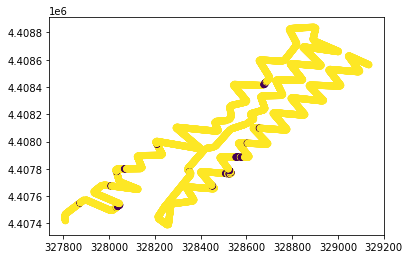

In [98]:
plt.scatter(x, y, c=median_selector)

In [99]:
data = data[median_selector]
chan = chan[median_selector]
x = x[median_selector]
y = y[median_selector]
z = z[median_selector]
azimuth = azimuth[median_selector]

len(x)

7646

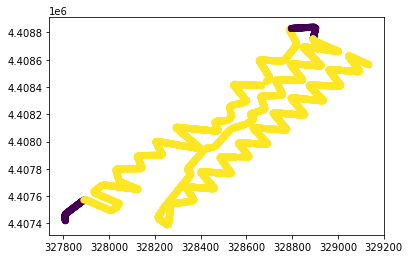

In [100]:
from scipy.spatial import Delaunay
import pandas as pd

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

nodal_metadata = pd.read_csv("Data/nodal_metadata.csv")
easting = nodal_metadata["UTM_easting_in_meters_final"].array
northing = nodal_metadata["UTM_northing_in_meters_final"].array
nodepoints = np.array([easting,northing]).T
points = np.array([x,y]).T
no_nodes_selector = in_hull(points,nodepoints)
plt.scatter(x, y, c=no_nodes_selector)
np.save("tmp/no_nodes_selector.npy", no_nodes_selector)

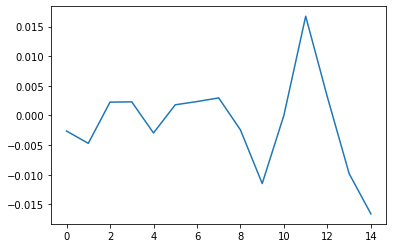

In [101]:
plt.plot(data[0,345:360])

In [102]:
from scipy.spatial import ConvexHull
points = np.array([x,y]).T
hull = ConvexHull(points)
hullpoints = points[hull.vertices]
np.save("Data/convex_hull_points.npy", hullpoints)

Go to Julia notebook to calculate the best fitting rectangle with a particular aspect ratio

In [103]:
corners = np.load("Data/rectangle_corners.npy")
vec1 = corners[:,0]-corners[:,1]
vec2 = corners[:,2]-corners[:,1]
l1 = np.sqrt(np.sum(np.square(vec1)))
l2 = np.sqrt(np.sum(np.square(vec2)))
t1 = np.linspace(0, l1, 33)
t2 = np.linspace(0, l2, 129)

t1 = (t1[1:]+t1[:-1])/2
t2 = (t2[1:]+t2[:-1])/2

domain_azimuth = np.rad2deg(np.arctan2(vec2[0], vec2[1]))
azimuth_corr = azimuth-domain_azimuth
rac = np.deg2rad(azimuth_corr)

In [104]:
domain_azimuth

35.860889779958171

In [105]:
points_corr = points-corners[:,1]
proj_1 = l1*(points_corr@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
proj_2 = l2*(points_corr@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()

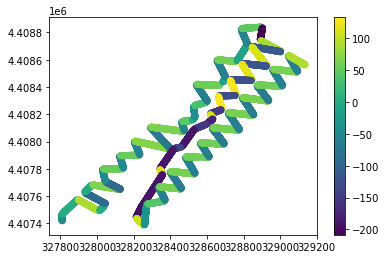

In [106]:
plt.scatter(x,y,c=azimuth_corr)
plt.colorbar()

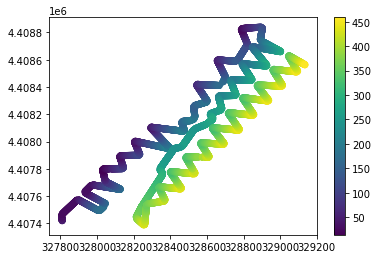

In [107]:
plt.scatter(x,y,c=proj_1)
plt.colorbar()

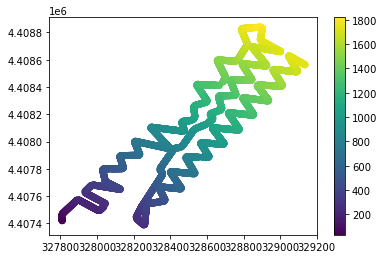

In [108]:
plt.scatter(x,y,c=proj_2)
plt.colorbar()

In [109]:
np.save("Data/dasdata.npy", data)

In [110]:
np.save("Data/filtdas.npy", butter_bandpass_filter(data, 1, 2.5, 1/dt))

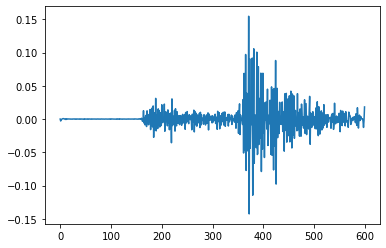

In [28]:
plt.plot(data[5000])

In [29]:
# from scipy.io import loadmat
# from scipy.interpolate import RectBivariateSpline as rbs
# from scipy.integrate import quad
# import scipy.sparse as sp

# cscale = 2

# generate_kernels = True

# L = 10 #gauge length

# if generate_kernels:
#     crv = loadmat("Data/G_32_128.mat")
#     G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], 32,128))
#     crvscales = crv["scales"].flatten()
#     cvtscaler = (2.0**(cscale*crvscales))
#     G1_rows = []
#     G1_cols = []
#     G1_vals = []
#     G2_rows = []
#     G2_cols = []
#     G2_vals = []
#     for j in range(G_mat.shape[0]):
#         frame = rbs(t1,t2,G_mat[j])
#         G1_col = (np.sin(rac)**2*frame.ev(proj_1,proj_2, dx=1) + 
#                   np.sin(2*rac)*frame.ev(proj_1,proj_2, dy=1)/2)
#         #noting we are using azimuth relative to proj_1
#         G1_selector = np.nonzero(np.log10(np.abs(G1_col))-np.max(np.log10(np.abs(G1_col))) > -3.0)[0] # if <0.1% max, get rid of it
#         G1_rows += [i for i in G1_selector]
#         G1_cols += [j for i in G1_selector]
#         G1_vals += [G1_col[i]/cvtscaler[j] for i in G1_selector]
        
        
#         G2_col = (np.cos(rac)**2*frame.ev(proj_1,proj_2, dy=1) + 
#                   np.sin(2*rac)*frame.ev(proj_1,proj_2, dx=1)/2)
#         G2_rows += [i for i in G2_selector]
#         G2_cols += [j for i in G2_selector]
#         G2_vals += [G2_col[i]/cvtscaler[j] for i in G2_selector]
        
    
#     G1 = sp.coo_matrix((G1_vals, (G1_rows, G1_cols)), shape=(len(x), G_mat.shape[0]))
#     G2 = sp.coo_matrix((G2_vals, (G2_rows, G2_cols)), shape=(len(x), G_mat.shape[0]))
#     G = sp.hstack([G1,G2])
#     Gn = np.sqrt(G.power(2).sum()/G.nnz - G.mean()**2)
#     G = G / Gn
#     Gevp = G_mat / cvtscaler[:,np.newaxis,np.newaxis] / Gn
#     sp.save_npz("Data/G.npz", G)
#     np.save("Data/G_evp.npy", Gevp)
#     np.save("Data/G.npy", G.todense())
#     sp.save_npz("Data/Gcsc.npz", G.tocsc())

    
# if not generate_kernels:
#     G = sp.load_npz("Data/Gcsc.npz")
#     Gevp = np.load("Data/G_evp.npy")
#     Gevp = np.reshape(Gevp, (Gevp.shape[0], 128*32))
        

In [82]:
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline as rbs
from scipy.integrate import romb
import scipy.sparse as sp

cscale = 2

generate_kernels = False

L = 10 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = proj_1[:,np.newaxis]+np.sin(rac[:,np.newaxis])*ll[np.newaxis,:]
p2 = proj_2[:,np.newaxis]+np.cos(rac[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    crv = loadmat("Data/G_32_128.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], 32,128))
    crvscales = crv["scales"].flatten()
    cvtscaler = (2.0**(cscale*crvscales))
    G1_rows = []
    G1_cols = []
    G1_vals = []
    G2_rows = []
    G2_cols = []
    G2_vals = []
    Gxx_rows = []
    Gxx_cols = []
    Gxx_vals = []
    Gxy_rows = []
    Gxy_cols = []
    Gxy_vals = []
    Gyx_rows = []
    Gyx_cols = []
    Gyx_vals = []
    Gyy_rows = []
    Gyy_cols = []
    Gyy_vals = []
    for j in range(G_mat.shape[0]):
        frame = rbs(t1,t2,G_mat[j])
        #average derivatives of frame along guage length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        #noting we are using azimuth relative to proj_1
        G1_col = (np.sin(rac)**2*fd1 + 
                  np.sin(2*rac)*fd2/2)
        #Currently set up so that it doesn't try to sparsify at all...(still creates a sparse matrix, but return to dense)
        G1_selector = np.nonzero(np.log10(np.abs(G1_col))-np.max(np.log10(np.abs(G1_col))) > -15.0)[0] # if <0.1% max, get rid of it
        G1_rows += [i for i in G1_selector]
        G1_cols += [j for i in G1_selector]
        G1_vals += [G1_col[i]/cvtscaler[j] for i in G1_selector]
        G2_col = (np.cos(rac)**2*fd2 + 
                  np.sin(2*rac)*fd1/2)
        G2_selector = np.nonzero(np.log10(np.abs(G2_col))-np.max(np.log10(np.abs(G2_col))) > -15.0)[0] # if <0.1% max, get rid of it
        G2_rows += [i for i in G2_selector]
        G2_cols += [j for i in G2_selector]
        G2_vals += [G2_col[i]/cvtscaler[j] for i in G2_selector]
        
        Gxx_col = np.sin(rac)**2*fd1
        #Currently set up so that it doesn't try to sparsify at all...(still creates a sparse matrix, but return to dense)
        Gxx_selector = np.nonzero(np.log10(np.abs(Gxx_col))-np.max(np.log10(np.abs(Gxx_col))) > -15.0)[0] # if <0.1% max, get rid of it
        Gxx_rows += [i for i in Gxx_selector]
        Gxx_cols += [j for i in Gxx_selector]
        Gxx_vals += [Gxx_col[i]/cvtscaler[j] for i in Gxx_selector]
        
        Gxy_col = np.sin(2*rac)*fd2/2
        Gxy_selector = np.nonzero(np.log10(np.abs(Gxy_col))-np.max(np.log10(np.abs(Gxy_col))) > -15.0)[0] # if <0.1% max, get rid of it
        Gxy_rows += [i for i in Gxy_selector]
        Gxy_cols += [j for i in Gxy_selector]
        Gxy_vals += [Gxy_col[i]/cvtscaler[j] for i in Gxy_selector]
        
        Gyx_col = np.sin(2*rac)*fd1/2
        Gyx_selector = np.nonzero(np.log10(np.abs(Gyx_col))-np.max(np.log10(np.abs(Gyx_col))) > -15.0)[0] # if <0.1% max, get rid of it
        Gyx_rows += [i for i in Gyx_selector]
        Gyx_cols += [j for i in Gyx_selector]
        Gyx_vals += [Gyx_col[i]/cvtscaler[j] for i in Gyx_selector]
        
        Gyy_col =  np.cos(rac)**2*fd2 
        Gyy_selector = np.nonzero(np.log10(np.abs(Gyy_col))-np.max(np.log10(np.abs(Gyy_col))) > -15.0)[0] # if <0.1% max, get rid of it
        Gyy_rows += [i for i in Gyy_selector]
        Gyy_cols += [j for i in Gyy_selector]
        Gyy_vals += [Gyy_col[i]/cvtscaler[j] for i in Gyy_selector]
    
    G1 = sp.coo_matrix((G1_vals, (G1_rows, G1_cols)), shape=(len(x), G_mat.shape[0]))
    G2 = sp.coo_matrix((G2_vals, (G2_rows, G2_cols)), shape=(len(x), G_mat.shape[0]))
    
    Gxx = sp.coo_matrix((Gxx_vals, (Gxx_rows, Gxx_cols)), shape=(len(x), G_mat.shape[0]))
    Gxy = sp.coo_matrix((Gxy_vals, (Gxy_rows, Gxy_cols)), shape=(len(x), G_mat.shape[0]))
    Gyx = sp.coo_matrix((Gyx_vals, (Gyx_rows, Gyx_cols)), shape=(len(x), G_mat.shape[0]))
    Gyy = sp.coo_matrix((Gyy_vals, (Gyy_rows, Gyy_cols)), shape=(len(x), G_mat.shape[0]))
    
    G = sp.hstack([G1,G2])
    Gn = np.sqrt(G.power(2).sum()/G.nnz - G.mean()**2)
    G = G / Gn
    Gxx = Gxx / Gn
    Gxy = Gxy / Gn
    Gyx = Gyx / Gn
    Gyy = Gyy / Gn
    Gevp = G_mat / cvtscaler[:,np.newaxis,np.newaxis] / Gn
    sp.save_npz("Data/G.npz", G)
    np.save("Data/Gxx.npy", Gxx.todense())
    np.save("Data/Gxy.npy", Gxy.todense())
    np.save("Data/Gyx.npy", Gyx.todense())
    np.save("Data/Gyy.npy", Gyy.todense())
    np.save("Data/G_evp.npy", Gevp)
    np.save("Data/G.npy", G.todense())
    sp.save_npz("Data/Gcsc.npz", G.tocsc())

    
if not generate_kernels:
    G = sp.load_npz("Data/Gcsc.npz")
    Gevp = np.load("Data/G_evp.npy")
    Gevp = np.reshape(Gevp, (Gevp.shape[0], 128*32))
        

In [83]:
Gn

5.4872922097808187e-06

In [31]:
import pywt
wvt = 'db12'
wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in data]).T
ncoefs, nstations = wvt_data.shape

np.save("Data/wvtdata.npy", wvt_data)


In [32]:
res = sp.load_npz("Results/results.npz")
res2 = sp.load_npz("Results2/results.npz")

In [33]:
pred = np.array((G*res).todense())
pred2 = np.array((G*res2).todense())

In [34]:
wvt_tmp = pywt.wavedec(data[0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [35]:
td_pred = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in pred]))
td_pred2 = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in pred2]))

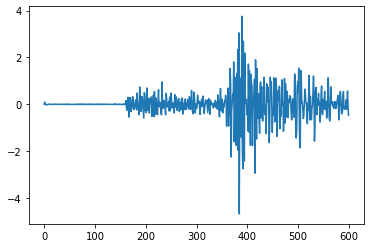

In [36]:
plt.plot(np.sum([d for (i,d) in enumerate(data) if ((chan[i] >= 498) and (chan[i] <= 541))], axis=0))

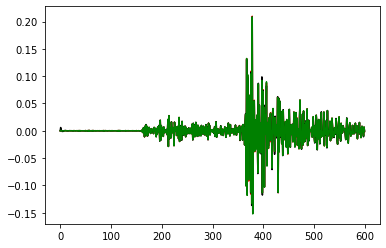

In [37]:
plt.plot(td_pred[1000],'r')
plt.plot(data[1000], 'k')
plt.plot(td_pred2[1000],'g')

In [38]:
sd = np.std(data)
data = data/sd
td_pred = td_pred/sd

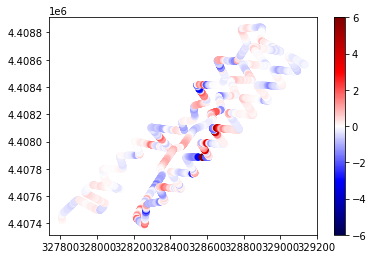

In [39]:
i = 500

norm = mpl.colors.Normalize(vmin=-6, vmax=6)

plt.scatter(x,y,c=data[:,i], cmap='seismic', norm=norm)
plt.colorbar()

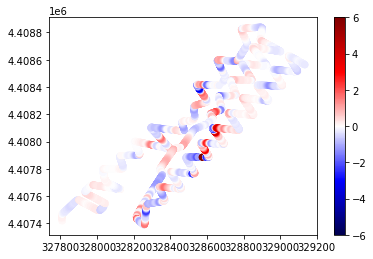

In [40]:
plt.scatter(x,y,c=td_pred[:,i], cmap='seismic', norm=norm)
plt.colorbar()

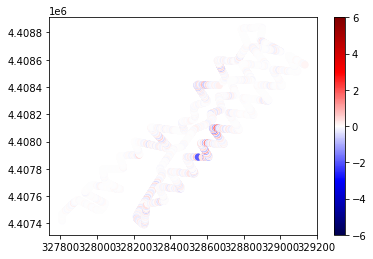

In [41]:
plt.scatter(x,y,c=data[:,i]-td_pred[:,i], cmap='seismic', norm=norm)
plt.colorbar()

In [42]:
1-np.sqrt(np.mean(np.square(data-td_pred)))/np.std(data)

0.7849452537043282

In [43]:
np.save("Data/data_comp.npy", data)

In [44]:
res_1 = res[:(res.shape[0]//2),:]
res_2 = res[(res.shape[0]//2):,:]

In [45]:
gr1 = Gevp.T@res_1
gr2 = Gevp.T@res_2

In [46]:
td_pred_1 = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in gr1]))/sd
td_pred_2 = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in gr2]))/sd

In [47]:
td_pred_1 = np.reshape(td_pred_1, (32,128, td_pred_1.shape[1]))
td_pred_2 = np.reshape(td_pred_2, (32,128, td_pred_2.shape[1]))
td_pred_n = np.sqrt(td_pred_1**2+td_pred_2**2) 

In [48]:
td_pred_n

array([[[ 5.59603956, 24.44717954, 10.76845881, ..., 43.64720703,
         22.9911987 , 82.923128  ],
        [ 6.08023617, 25.78929815, 10.51719266, ..., 49.28084534,
         25.90321978, 80.27989079],
        [ 6.61316536, 24.66362174,  9.32753934, ..., 52.30521753,
         27.94233908, 73.08584826],
        ...,
        [ 7.85638433, 17.74134087, 12.56923043, ..., 32.81002585,
         22.50230195, 80.40429517],
        [ 7.28438293, 20.63212863, 10.99685886, ..., 35.22554521,
         21.0043433 , 79.96419343],
        [ 5.39123206, 24.19805033, 10.26815373, ..., 38.16145908,
         21.30495589, 78.17640015]],

       [[ 5.91488031, 19.83244856,  8.70763018, ..., 46.81444414,
         27.63624836, 85.40195262],
        [ 5.94013843, 19.69720844,  7.68232198, ..., 54.18161044,
         31.6339183 , 85.7647745 ],
        [ 6.3321048 , 19.89243951,  7.20596039, ..., 58.54634301,
         34.31776783, 81.6219441 ],
        ...,
        [ 6.53315208, 28.56281853, 16.27857131, ..., 3

In [49]:
# from matplotlib import animation
# fig, ax = plt.subplots(1,1, figsize=(12,8))

# i = 0

# #matplotlib bug means we need to add a mini jitter to color function to get it to plot

# fig.suptitle("Time = 0 s", fontsize=16)

# nm = np.max(td_pred_n)
# norm = mpl.colors.Normalize(vmin=-nm, vmax=nm)
# q = ax.quiver(t2,t1, 
#            td_pred_1[:,:,i], 
#            td_pred_2[:,:,i],
#            np.sign(np.arctan2(td_pred_1[:,:,i], 
#                               td_pred_2[:,:,i]))*td_pred_n[:,:,i], cmap='seismic', norm=norm, scale=2e3)

# def update_quivers(i):
#     fig.suptitle(f"Time = {i*dt} s", fontsize=16)
#     q.set_UVC(td_pred_1[:,:,i], 
#               td_pred_2[:,:,i],
#               np.sign(np.arctan2(td_pred_1[:,:,i], 
#                               td_pred_2[:,:,i]))*td_pred_n[:,:,i])

# anim = animation.FuncAnimation(fig, update_quivers, frames=range(0, td_pred_1.shape[2]), interval=100, blit=False)

# # Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

# anim.save('im.mp4', writer=writer)

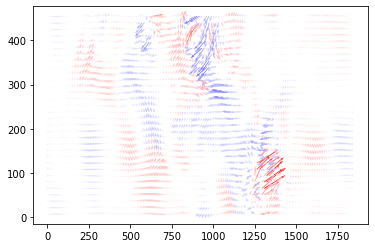

In [50]:
i = 415
nm = np.max(td_pred_n)
norm = mpl.colors.Normalize(vmin=-nm, vmax=nm)
plt.quiver(t2,t1, 
           td_pred_1[:,:,i], 
           td_pred_2[:,:,i],
           np.sign(np.arctan2(td_pred_1[:,:,i], 
                              td_pred_2[:,:,i]))*td_pred_n[:,:,i], cmap='seismic', norm=norm)

In [51]:
import pandas as pd

nodal_metadata = pd.read_csv("Data/nodal_metadata.csv")
nodal_metadata.loc[100,:]

Station                                                 N101
Latitude_in_deg_final                                39.8075
Longitude_in_deg_final                              -119.001
UTM_easting_in_meters_final                           328674
UTM_northing_in_meters_final                     4.40831e+06
Height_above_WGS84_ellipsoid_in_meters_final         1249.11
Height_above_unkown_geoid_in_meters_final            1273.52
Start_Date                                        2016-03-10
Start_Time                                      21:57:15.772
Stop_Date                                         2016-03-26
Stop_Time                                       18:33:16.772
Orientation_from_true_North                                0
Notes                                                    NaN
Name: 100, dtype: object

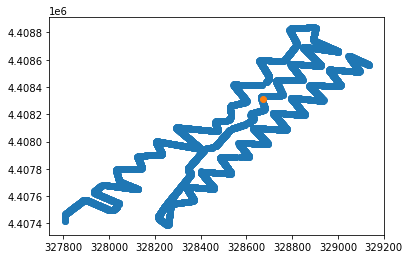

In [52]:
plt.scatter(x, y)
xn = nodal_metadata["UTM_easting_in_meters_final"][100]
yn = nodal_metadata["UTM_northing_in_meters_final"][100]
plt.scatter(xn, yn)

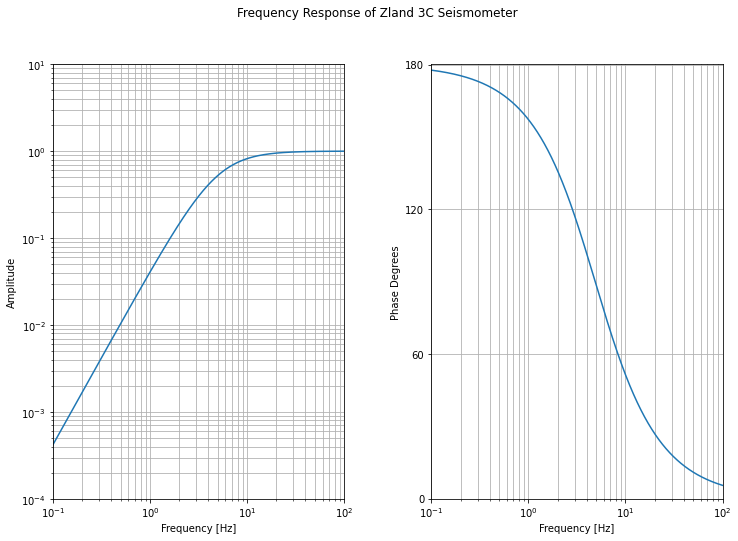

In [53]:
from obspy.signal.invsim import corn_freq_2_paz, paz_to_freq_resp

paz_5hz = corn_freq_2_paz(4.87, damp=0.98)  # 5Hz instrument average Ringler et al 2018

h, f = paz_to_freq_resp(paz_5hz['poles'], paz_5hz['zeros'], paz_5hz['gain'], 0.002, 16384*2**4, freq=True)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.loglog(f, abs(h))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(which='both')
plt.xlim(1e-1, 1e2)
plt.ylim(1e-4,1e1)


plt.subplot(122)
phase = np.rad2deg(2 * np.pi + np.unwrap(np.angle(h)))-360
plt.semilogx(f, phase)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase Degrees')
# ticks and tick labels at multiples of pi
plt.yticks(
    [0, 60, 120, 180])
plt.ylim(-0.2, 180 + 0.2)
plt.xlim(1e-1, 1e2)
plt.grid(which='both')

# title, centered above both subplots
plt.suptitle('Frequency Response of Zland 3C Seismometer')
# make more room in between subplots for the ylabel of right plot
plt.subplots_adjust(wspace=0.3)
plt.show()

In [54]:
import obspy

nodal = obspy.read("Data/20160321000016772.101.*.sac")
nodal.detrend()
nodal.taper(0.01)
nodal.filter('bandpass', freqmin=0.1,freqmax=20, zerophase=True)
nodal.simulate(paz_remove=paz_5hz, paz_simulate=None, remove_sensitivity=True, simulate_sensitivity=False)
nodal.filter('bandpass', freqmin=1, freqmax=20, zerophase=True)
starttime = obspy.UTCDateTime(2016,3,21,7,37,21)
endtime = obspy.UTCDateTime(2016,3,21,7,37,21)+60
nodal.trim(starttime,endtime)
nodal.decimate(5)
nodal.decimate(10)

2 Trace(s) in Stream:
PG.101..EHE | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.101..EHN | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples

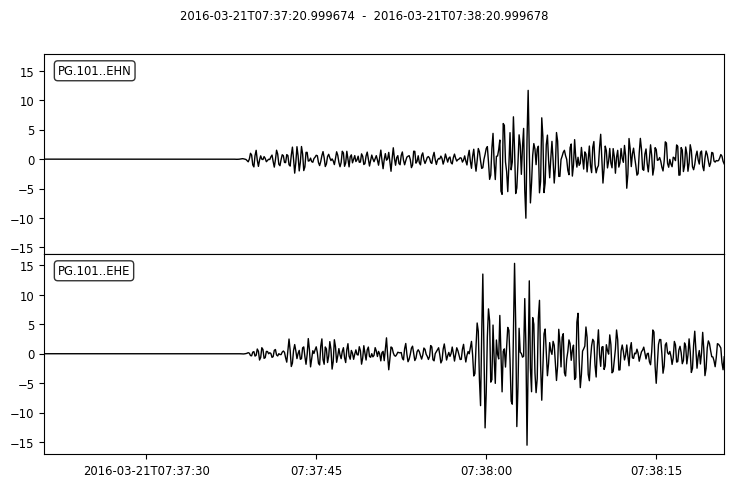

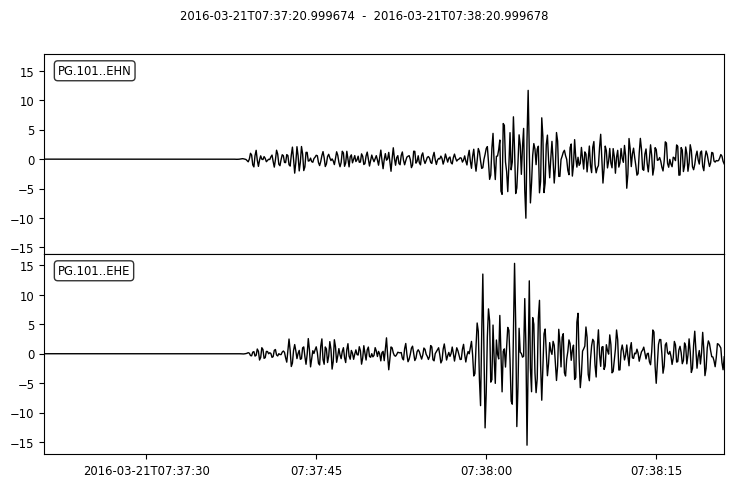

In [55]:
nodal.plot()

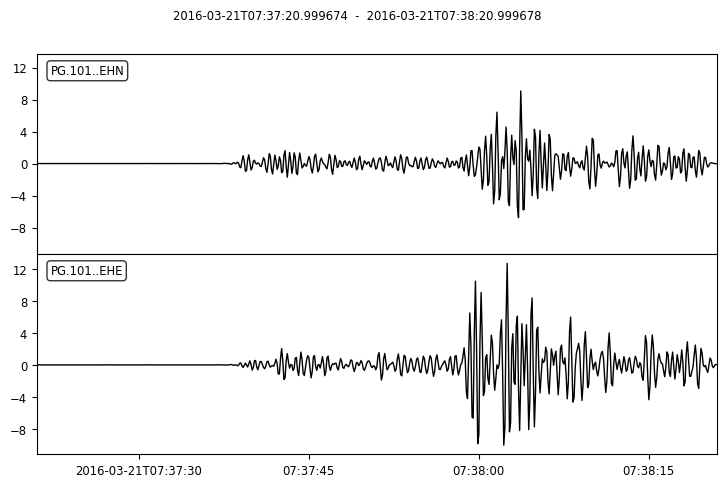

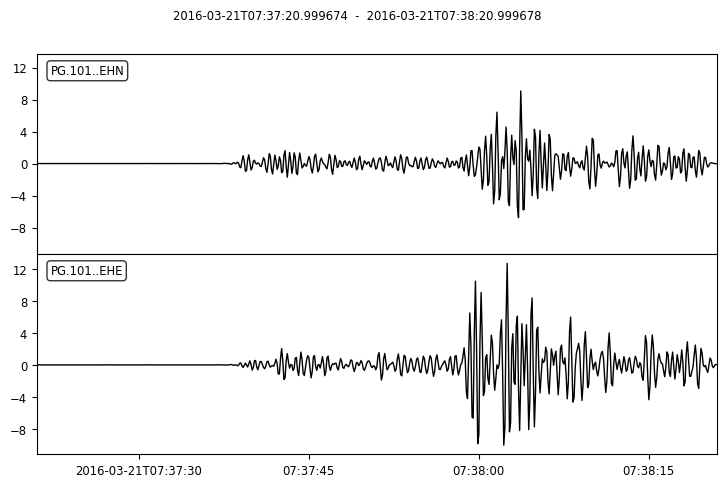

In [56]:
nodal.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).plot()

In [57]:
points_n = np.array([xn,yn])-corners[:,1]
proj_n_1 = l1*(points_n@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
proj_n_2 = l2*(points_n@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()

In [58]:
from scipy.interpolate import RectBivariateSpline as rbs

In [59]:
frames_1 = [rbs(t1,t2,td_pred_1[:,:,i]) for i in range(td_pred_1.shape[2])]
frames_2 = [rbs(t1,t2,td_pred_2[:,:,i]) for i in range(td_pred_2.shape[2])]

pred_n_1 = np.array([f1(xn,yn)[0,0] for f1 in frames_1])
pred_n_2 = np.array([f2(xn,yn)[0,0] for f2 in frames_2])

In [60]:
c = np.cos(np.deg2rad(domain_azimuth))
s = np.sin(np.deg2rad(domain_azimuth))
R = np.array([[c,-s],[s,c]])
pred_n_e, pred_n_n = R @ np.array([pred_n_1, pred_n_2])

In [61]:
nodal_pred = nodal.copy()
nodal_pred.select(channel="EHE")[0].data = pred_n_e*sd
nodal_pred.select(channel="EHN")[0].data = pred_n_n*sd

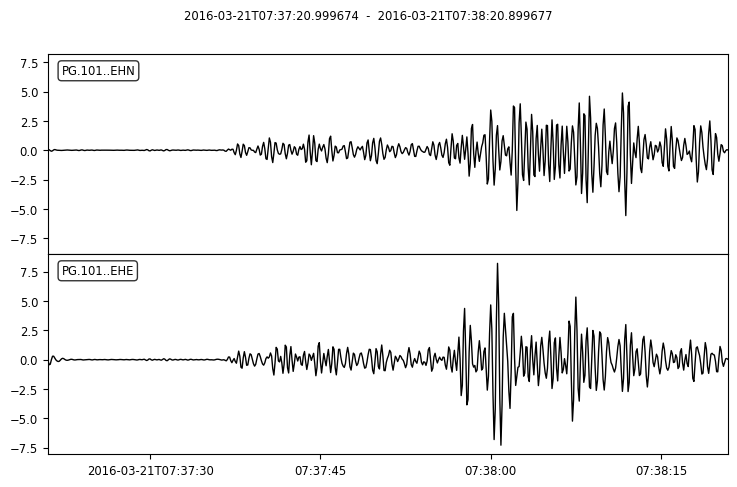

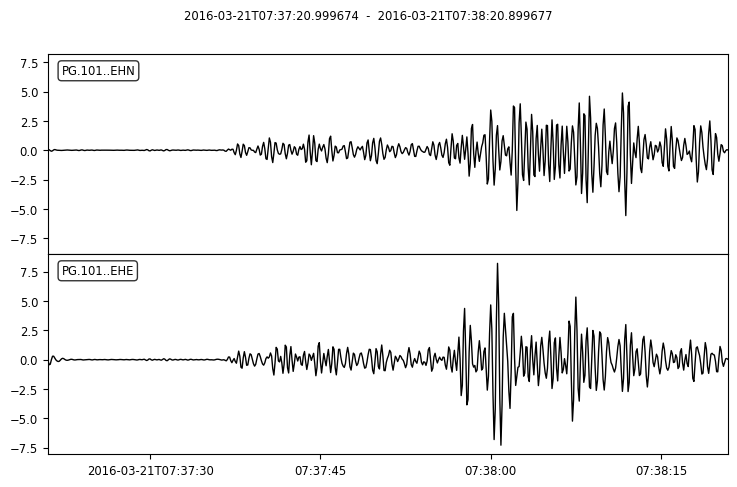

In [62]:
nodal_pred.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).plot()

In [63]:
nodal_e = nodal.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).select(channel="EHE")[0]
nodal_n = nodal.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).select(channel="EHN")[0]

In [64]:
nodal_pred_e = nodal_pred.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).select(channel="EHE")[0]
nodal_pred_n = nodal_pred.copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True).select(channel="EHN")[0]

Text(0.08, 0.5, 'Ground Velocity ($\\mu$ m s$^{-1}$)')

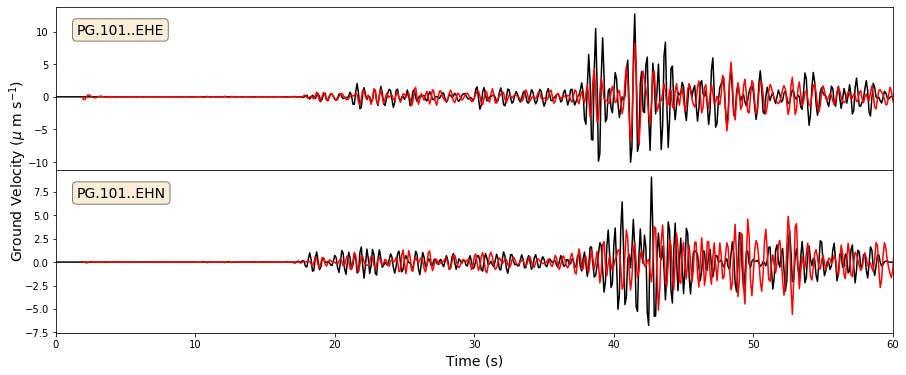

In [65]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

fig, axes = plt.subplots(2,1,figsize=(15,6))
axes[0].plot(nodal_e.times(), nodal_e.data, color='k')
axes[0].plot(nodal_pred_e.times()+19*nodal_pred_e.stats.delta, nodal_pred_e.data, color='r')
axes[0].text(0.025, 0.9, "PG.101..EHE", transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

axes[1].plot(nodal_n.times(), nodal_n.data, color='k')
axes[1].plot(nodal_pred_n.times()+19*nodal_pred_e.stats.delta, nodal_pred_n.data, color='r')
axes[1].text(0.025, 0.9, "PG.101..EHN", transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

for (i, ax) in enumerate(axes):
    ax.set_xlim(0,60)
    if i != (len(axes)-1):
        ax.set_xticks([])
    else:
        ax.set_xlabel("Time (s)", fontsize=14)
    
fig.subplots_adjust(hspace=0.0)
fig.text(0.08, 0.5, r'Ground Velocity ($\mu$ m s$^{-1}$)', va='center', rotation='vertical', fontsize=14)

In [66]:
evla = 38.479
evlo = -118.366

stla = 39.8
stlo = -119.01

dist, az, baz = obspy.geodetics.gps2dist_azimuth(evla, evlo, stla, stlo)

In [67]:
baz

159.00681551441272

[  613.  1744.  2895.  5556.  6233.  4906.  7461.]


Snippets/common_functions_and_variables.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  We are assuming that dataset1 and dataset2 are aligned


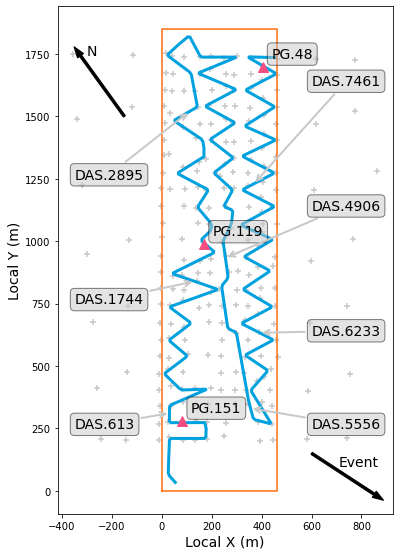

In [68]:
chanidx = [500,1500,2500,4900,5500,4300,6550]
channames = chan[chanidx]
print(channames)
plotx = proj_1[chanidx]
ploty = proj_2[chanidx]
pnx = [-350, -350, -350, 600, 600, 600, 600]
pny = [250, 750, 1250, 250, 625, 1125, 1625]

props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

xn = nodal_metadata["UTM_easting_in_meters_final"]
yn = nodal_metadata["UTM_northing_in_meters_final"]
points_n = np.array([xn,yn]).T-corners[:,1]
proj_n_1 = l1*(points_n@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
proj_n_2 = l2*(points_n@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()
xm = np.sqrt(np.sum(np.square(vec1)))
ym = np.sqrt(np.sum(np.square(vec2)))

np.save("tmp/proj_n_1", proj_n_1)
np.save("tmp/proj_n_2", proj_n_2)

np.save("tmp/proj_1", proj_1)
np.save("tmp/proj_2", proj_2)

plt.figure(figsize=(6,10))
plt.plot(proj_1, proj_2, lw=3, color=colorb)
plt.plot([0, xm, xm, 0, 0], [0, 0, ym, ym, 0], color=coloro)
plt.scatter(proj_n_1, proj_n_2, marker='+', color=colorgr)
plt.xlabel("Local X (m)", fontsize=14)
plt.ylabel("Local Y (m)", fontsize=14)

for stanum, sta in zip([47,118,150],["48","119","151"]):
    xn = nodal_metadata["UTM_easting_in_meters_final"][stanum]
    yn = nodal_metadata["UTM_northing_in_meters_final"][stanum]
    points_n = np.array([xn,yn])-corners[:,1]
    proj_n_1 = l1*(points_n@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
    proj_n_2 = l2*(points_n@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()
    plt.plot(proj_n_1, proj_n_2, marker='^', color=colorp, markersize=10)
    plt.text(proj_n_1+35, proj_n_2+35, f"PG.{sta}", fontsize=14, bbox=props)
    
    
for cx, cy, cn, cpx, cpy in zip(plotx, ploty, channames, pnx, pny):
    plt.annotate(f"DAS.{int(cn)}", 
                 xy=(cx,cy), 
                 xytext=(cpx, cpy), 
                 fontsize=14, 
                 bbox=props,  
                 arrowprops=dict(arrowstyle="->", color=colorgr, linewidth=2))

alen = 300
plt.arrow(-150,1500, alen*np.sin(-np.deg2rad(domain_azimuth)), alen*np.cos(-np.deg2rad(domain_azimuth)), width=10, facecolor='k', edgecolor='k')
plt.arrow(600,150, alen*np.sin(np.deg2rad(baz-domain_azimuth)), alen*np.cos(np.deg2rad(baz-domain_azimuth)), width=10, facecolor='k', edgecolor='k')

plt.text(-300, 1745, 'N', fontsize=14)
plt.text(710, 100, 'Event', fontsize=14)

plt.axes().set_aspect('equal')
plt.savefig("bradydeployment.pdf")

In [69]:
import obspy

nodal = obspy.read("Data/2016*.sac")
nodal.detrend()
nodal.taper(0.01)
nodal.filter('bandpass', freqmin=0.1,freqmax=20, zerophase=True)
nodal.simulate(paz_remove=paz_5hz, paz_simulate=None, remove_sensitivity=True, simulate_sensitivity=False)
starttime = obspy.UTCDateTime(2016,3,21,7,37,21)
endtime = obspy.UTCDateTime(2016,3,21,7,37,21)+60
nodal.trim(starttime,endtime)
nodal.decimate(5)
nodal.decimate(10)

8 Trace(s) in Stream:
PG.48..EHE  | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.48..EHN  | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.151..EHE | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.151..EHN | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.119..EHE | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.119..EHN | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.101..EHE | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples
PG.101..EHN | 2016-03-21T07:37:20.999674Z - 2016-03-21T07:38:20.999678Z | 10.0 Hz, 601 samples

In [70]:
nodal_pred = nodal.copy()

In [71]:
nodal_metadata.loc[47,:]

Station                                                 N048
Latitude_in_deg_final                                39.8099
Longitude_in_deg_final                              -118.997
UTM_easting_in_meters_final                           329070
UTM_northing_in_meters_final                     4.40856e+06
Height_above_WGS84_ellipsoid_in_meters_final         1258.05
Height_above_unkown_geoid_in_meters_final            1282.46
Start_Date                                        2016-03-10
Start_Time                                      23:04:10.700
Stop_Date                                         2016-03-26
Stop_Time                                       20:34:11.700
Orientation_from_true_North                                3
Notes                                                    NaN
Name: 47, dtype: object

In [72]:
nodal_metadata.loc[100,:]

Station                                                 N101
Latitude_in_deg_final                                39.8075
Longitude_in_deg_final                              -119.001
UTM_easting_in_meters_final                           328674
UTM_northing_in_meters_final                     4.40831e+06
Height_above_WGS84_ellipsoid_in_meters_final         1249.11
Height_above_unkown_geoid_in_meters_final            1273.52
Start_Date                                        2016-03-10
Start_Time                                      21:57:15.772
Stop_Date                                         2016-03-26
Stop_Time                                       18:33:16.772
Orientation_from_true_North                                0
Notes                                                    NaN
Name: 100, dtype: object

In [73]:
nodal_metadata.loc[118,:]

Station                                                 N119
Latitude_in_deg_final                                39.8058
Longitude_in_deg_final                              -119.004
UTM_easting_in_meters_final                           328462
UTM_northing_in_meters_final                     4.40813e+06
Height_above_WGS84_ellipsoid_in_meters_final         1243.33
Height_above_unkown_geoid_in_meters_final            1267.75
Start_Date                                        2016-03-11
Start_Time                                      00:45:45.400
Stop_Date                                         2016-03-26
Stop_Time                                       17:15:46.400
Orientation_from_true_North                              357
Notes                                                    NaN
Name: 118, dtype: object

In [74]:
nodal_metadata.loc[150,:]

Station                                                 N151
Latitude_in_deg_final                                 39.801
Longitude_in_deg_final                              -119.009
UTM_easting_in_meters_final                           327977
UTM_northing_in_meters_final                      4.4076e+06
Height_above_WGS84_ellipsoid_in_meters_final         1228.21
Height_above_unkown_geoid_in_meters_final            1252.64
Start_Date                                        2016-03-07
Start_Time                                      22:25:15.160
Stop_Date                                         2016-03-26
Stop_Time                                       24:00:16.170
Orientation_from_true_North                              357
Notes                                                    NaN
Name: 150, dtype: object

In [75]:
for stanum, sta in zip([47,100,118,150],["48","101","119","151"]):
    xn = nodal_metadata["UTM_easting_in_meters_final"][stanum]
    yn = nodal_metadata["UTM_northing_in_meters_final"][stanum]
    points_n = np.array([xn,yn])-corners[:,1]
    proj_n_1 = l1*(points_n@vec1[:,np.newaxis] / np.sum(np.square(vec1))).flatten()
    proj_n_2 = l2*(points_n@vec2[:,np.newaxis] / np.sum(np.square(vec2))).flatten()

    frames_1 = [rbs(t1,t2,td_pred_1[:,:,i]) for i in range(td_pred_1.shape[2])]
    frames_2 = [rbs(t1,t2,td_pred_2[:,:,i]) for i in range(td_pred_2.shape[2])]

    pred_n_1 = np.array([f1(xn,yn)[0,0] for f1 in frames_1])
    pred_n_2 = np.array([f2(xn,yn)[0,0] for f2 in frames_2])

    pred_n_e, pred_n_n = R @ np.array([pred_n_1, pred_n_2])

    nodal_pred.select(station=sta, channel="EHE")[0].data = pred_n_e*sd
    nodal_pred.select(station=sta, channel="EHN")[0].data = pred_n_n*sd

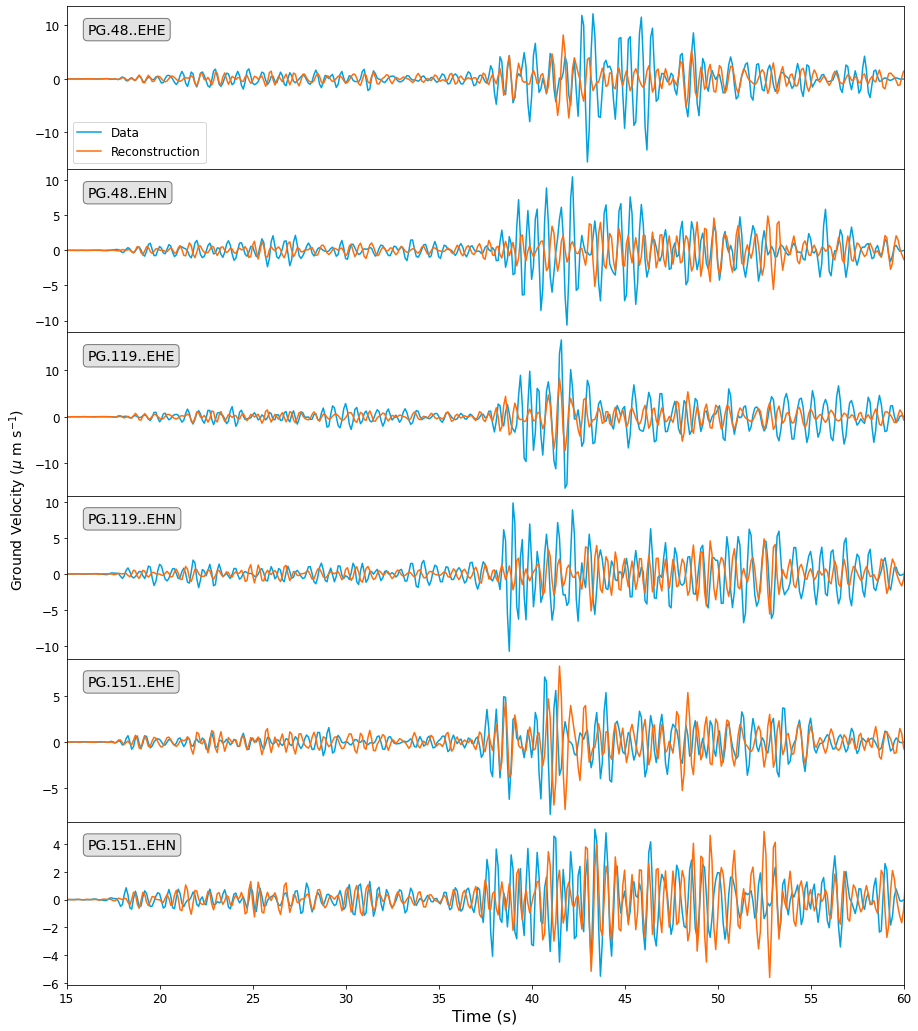

In [76]:
props = dict(boxstyle='round', facecolor=colorgr, alpha=0.5)

fig, axes = plt.subplots(6,1,figsize=(15,18))

nodal_e = nodal.select(station="48", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_n = nodal.select(station="48", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_e = nodal_pred.select(station="48", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_n = nodal_pred.select(station="48", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]



axes[0].plot(nodal_e.times(), nodal_e.data, color=colorb, label="Data")
axes[0].plot(nodal_pred_e.times()+21*nodal_pred_e.stats.delta, nodal_pred_e.data, color=coloro, label="Reconstruction")
axes[0].text(0.025, 0.9, "PG.48..EHE", transform=axes[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
axes[0].legend(loc="lower left", fontsize=12)

axes[1].plot(nodal_n.times(), nodal_n.data, color=colorb)
axes[1].plot(nodal_pred_n.times()+21*nodal_pred_e.stats.delta, nodal_pred_n.data, color=coloro)
axes[1].text(0.025, 0.9, "PG.48..EHN", transform=axes[1].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

nodal_e = nodal.select(station="119", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_n = nodal.select(station="119", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_e = nodal_pred.select(station="119", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_n = nodal_pred.select(station="119", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]

axes[2].plot(nodal_e.times(), nodal_e.data, color=colorb)
axes[2].plot(nodal_pred_e.times()+19*nodal_pred_e.stats.delta, nodal_pred_e.data, color=coloro)
axes[2].text(0.025, 0.9, "PG.119..EHE", transform=axes[2].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

axes[3].plot(nodal_n.times(), nodal_n.data, color=colorb)
axes[3].plot(nodal_pred_n.times()+19*nodal_pred_e.stats.delta, nodal_pred_n.data, color=coloro)
axes[3].text(0.025, 0.9, "PG.119..EHN", transform=axes[3].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


nodal_e = nodal.select(station="151", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_n = nodal.select(station="151", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_e = nodal_pred.select(station="151", channel="EHE").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]
nodal_pred_n = nodal_pred.select(station="151", channel="EHN").copy().filter('bandpass', freqmin=1,freqmax=2.5, zerophase=True)[0]


axes[4].plot(nodal_e.times(), nodal_e.data, color=colorb)
axes[4].plot(nodal_pred_e.times()+19*nodal_pred_e.stats.delta, nodal_pred_e.data, color=coloro)
axes[4].text(0.025, 0.9, "PG.151..EHE", transform=axes[4].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

axes[5].plot(nodal_n.times(), nodal_n.data, color=colorb )
axes[5].plot(nodal_pred_n.times()+19*nodal_pred_e.stats.delta, nodal_pred_n.data, color=coloro)
axes[5].text(0.025, 0.9, "PG.151..EHN", transform=axes[5].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


for (i, ax) in enumerate(axes):
    ax.set_xlim(15,60)
    if i != (len(axes)-1):
        axes[i].set_xticks([])
        axes[i].tick_params(axis='y', labelsize=12)
    else:
        axes[i].set_xlabel("Time (s)", fontsize=16)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
    
    
fig.subplots_adjust(hspace=0.0)
# fig.text(0.07, 0.5, r'Strain (ns s$^{-1}$)', va='center', rotation='vertical', fontsize=16)


fig.text(0.07, 0.5, r'Ground Velocity ($\mu$ m s$^{-1}$)', va='center', rotation='vertical', fontsize=14)
fig.savefig("nodalcomparison.pdf")

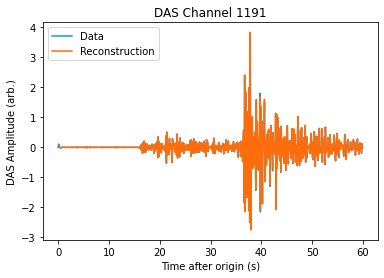

In [77]:
plt.figure(figsize=(6,4))
plt.plot(nodal_pred_e.times(), data[1000], colorb, label="Data")
plt.plot(nodal_pred_e.times(), td_pred[1000],coloro, label="Reconstruction")
plt.title(f"DAS Channel {int(chan[1000])}")
plt.xlabel("Time after origin (s)")
plt.ylabel("DAS Amplitude (arb.)")
plt.legend(loc="upper left")
plt.savefig("das_matching.pdf")